## GEOG0125

Advanced Topics in Social and Geographic Data Science
-----------------------------------

Detecting Ships in Satellite Port Images Using Pre-Trained Convolutional Neural Networks
-------------------------------

## 1. Loading Libraries

In [3]:
# install necessary libraries before import
!pip install captum
# install numpy version compatible with OpenCV
!pip install numpy==1.23.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
# python standard modules
# numerical computing and matrix operations
import numpy as np
# data manipulation and analysis
import pandas as pd
# basic plotting and visualisation
import matplotlib.pyplot as plt
# statistical data visualisation
import seaborn as sns
# operating system interface
import os
# Python imaging library to open, manage, or convert image files
from PIL import Image
# display imaages in Jupyter notebooks from files/URLs
from IPython.display import Image as IPyImage, display
# python object serialisation to save model and parameters
import pickle

# sklearn standard functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# core PyTorch modules for deep learning
import torch # main PyTorch module
import torch.nn as nn # neural network layers and loss functions
import torch.optim as optim # Optimisers (SGD, Adam, etc.)
import torch.nn.functional as F # Functional API (e.g. F.relu, F.softmax)
from torch.utils.data import DataLoader, TensorDataset # efficient data loading and batching
from torch.utils.data import Dataset # base class for creating custom datasets in PyTorch

# torchvision modules for image pre-procesisng and pretrained models
import torchvision # high-level image models and datasets
import torchvision.transforms as transforms # preprocessing transformations (resize, normalise, etc.)
from torchvision.io import read_image # to read an image from disk into a PyTorch tensor
from torchvision import datasets # datasets provides pre-defined image datasets commonly used in coputer vision research
from torchvision import models # models grants access to pre-trained models for image classification, object detection, segmentation etc.
from torchvision.models import vgg11_bn, resnet50, efficientnet_b0 # pre-trained image classification models from torchvision

# Captum provides interpretability to model predictions
from captum.attr import Occlusion # helps understand which regions of the image the model relied on to make a decision
from captum.attr import visualization as viz # utility module for plotting attribution maps

# OpenCV library is used for image processing tasks like reading, writing, and manipulating images (drawing boxes and applying color maps)
import cv2

In [2]:
# fix random seeds for reproducibility
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# mount my Drive to the Colab runtime
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Dataset Preparation

In [4]:
# set paths
# ShipsNet is a labeled training dataset consiting of images extracted from Planet satellite imagery
# It contains hundreds of 80x80 pixel RGB image chips labeled with either a "ship" or "no-ship" classification
img_dir = '/content/drive/MyDrive/GEOG0125/shipsnet/'
output_dir = '/content/drive/MyDrive/GEOG0125/'

# list all image files
image_files = os.listdir(img_dir)

# filter for only PNG image files
image_files = [f for f in image_files if f.endswith('.png')]

# extract labels from filenames
data = []
for fname in image_files:
  label = int(fname.split('_')[0]) # 0 or 1
  data.append((fname, label))

# save to CSV
ships_df = pd.DataFrame(data, columns = ['imgID', 'label'])
ships_df.to_csv(os.path.join(output_dir,'ships_labels.csv'), index=False)

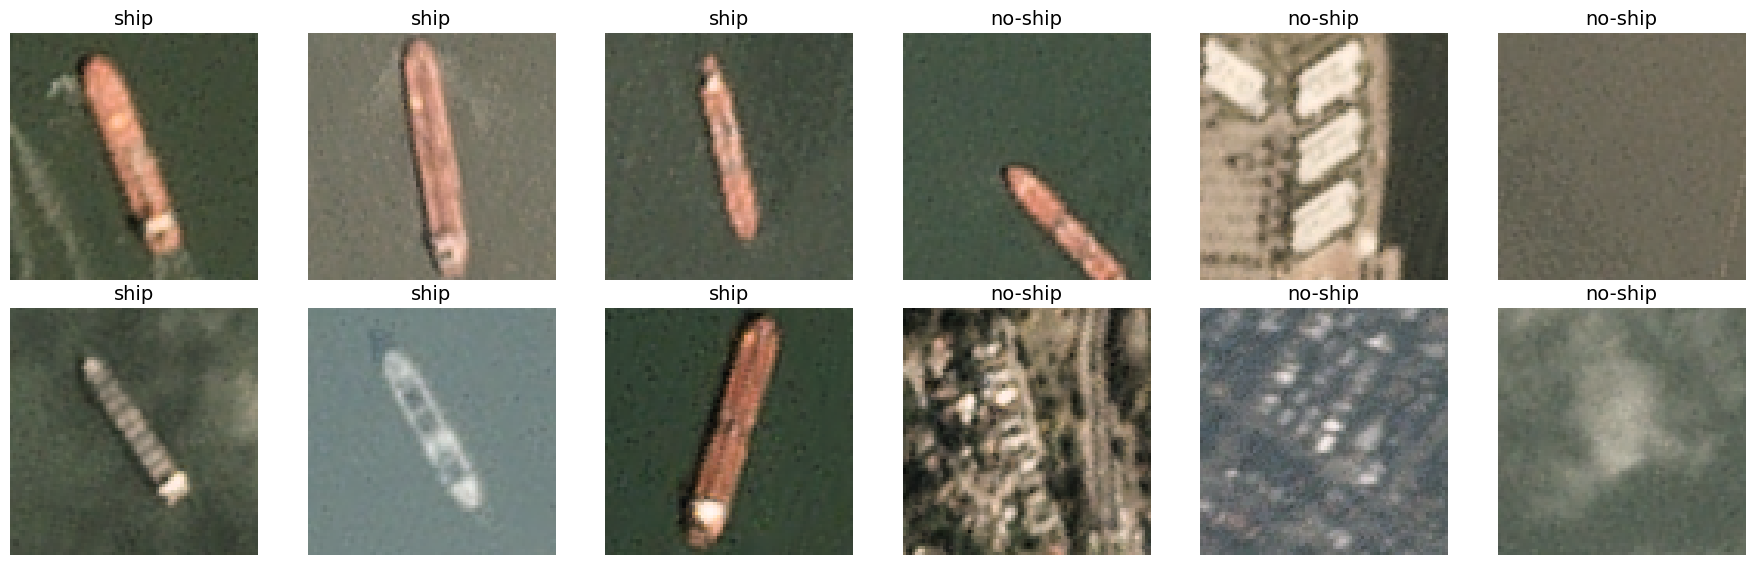

In [5]:
# path settings
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)

# separate ship and no-ship examples
ship_samples = ships_df[ships_df['label'] == 1].sample(6, random_state=42)  # 6 random ships
noship_samples = ships_df[ships_df['label'] == 0].sample(6, random_state=42)  # 6 random no-ships

# function to load and preprocess image for display
def load_image_for_display(img_path):
    img = Image.open(img_path)
    img = img.resize((80, 80))
    return img

# plot grid (2 rows x 6 columns)
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

# plot ship images (first 6)
for idx, img_id in enumerate(ship_samples['imgID']):
    img_path = os.path.join(img_dir, img_id)
    img = load_image_for_display(img_path)
    row = idx // 3  # 0 or 1
    col = idx % 3   # 0, 1, 2
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title('ship', fontsize=14)

# plot no-ship images (next 6)
for idx, img_id in enumerate(noship_samples['imgID']):
    img_path = os.path.join(img_dir, img_id)
    img = load_image_for_display(img_path)
    row = idx // 3  # 0 or 1
    col = idx % 3 + 3  # shift by 3 columns to the right
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title('no-ship', fontsize=14)

# set overall title
# plt.suptitle('Example Ship and No-Ship Images', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])

# save figure
fig.savefig(os.path.join(assets_path, 'ship_vs_noship_examples.png'), dpi=300)

# show plot
plt.show()

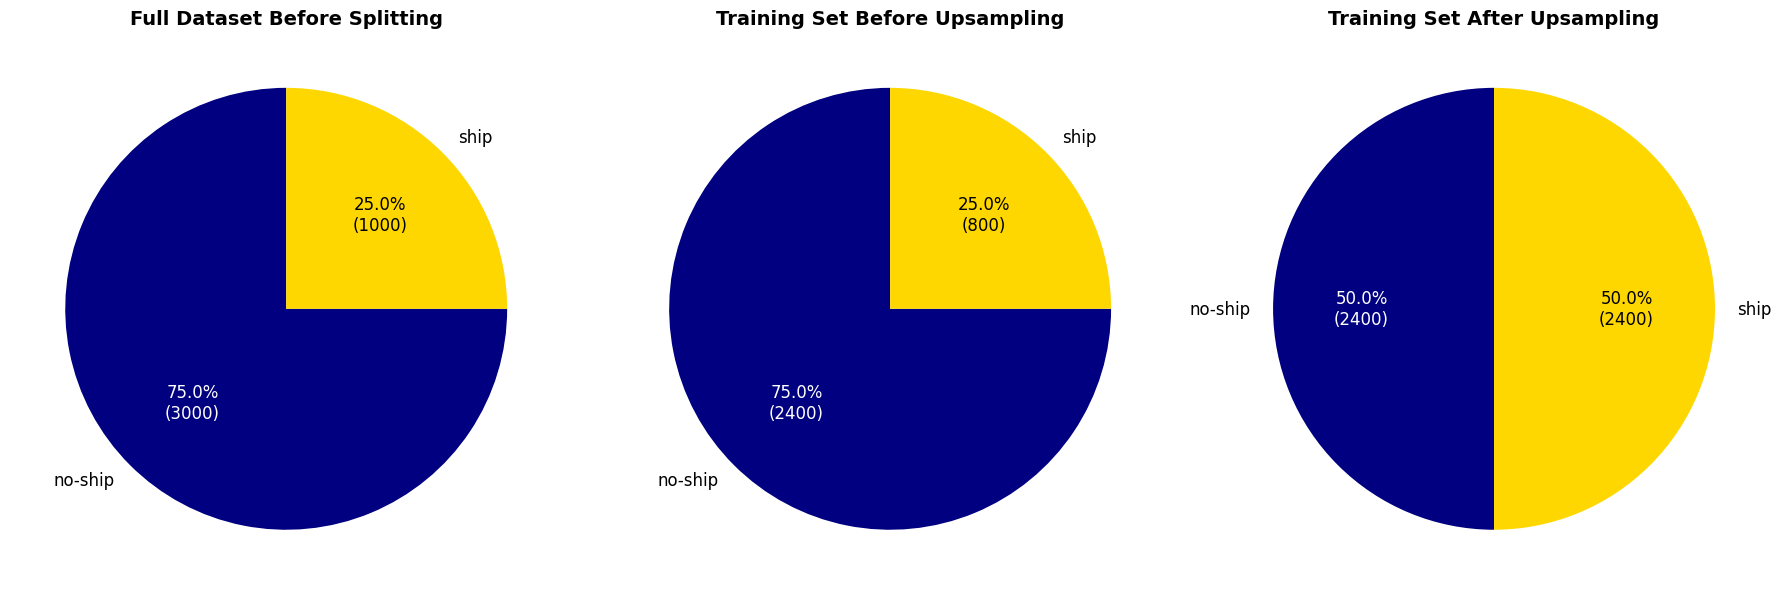

In [6]:
# define function to show count + percent inside pie chart
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return my_format

# define colors
colors = ['navy', 'gold']

# prepare split
train_df, test_df = train_test_split(ships_df, test_size=0.2, stratify=ships_df['label'], random_state=42)

# split the training set by class
ship_train_df = train_df[train_df['label'] == 1]
noship_train_df = train_df[train_df['label'] == 0]

# upsample 'ship' class to match 'no-ship' in training set
ship_train_upsampled = ship_train_df.sample(len(noship_train_df), replace=True, random_state=42)

# merge and shuffle the balanced training set
train_df_balanced = pd.concat([noship_train_df, ship_train_upsampled], axis=0).sample(frac=1, random_state=42)

# create 3 side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# plot 1: full dataset before splitting
wedges, texts, autotexts = axes[0].pie(
    ships_df['label'].value_counts(),
    labels=['no-ship', 'ship'],
    autopct=autopct_format(ships_df['label'].value_counts()),
    colors=colors,
    startangle=90
)
axes[0].set_title('Full Dataset Before Splitting', fontsize=14, fontweight='bold')
axes[0].set_ylabel('')

# format text/font
for i, (text, autotext) in enumerate(zip(texts, autotexts)):
    text.set_fontsize(12)
    autotext.set_fontsize(12)
    if i == 0:
        autotext.set_color('white')
    else:
        autotext.set_color('black')

# plot 2: training set before upsampling
wedges1, texts1, autotexts1 = axes[1].pie(
    train_df['label'].value_counts(),
    labels=['no-ship', 'ship'],
    autopct=autopct_format(train_df['label'].value_counts()),
    colors=colors,
    startangle=90
)
axes[1].set_title('Training Set Before Upsampling', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

# format text/font
for i, (text, autotext) in enumerate(zip(texts1, autotexts1)):
    text.set_fontsize(12)
    autotext.set_fontsize(12)
    if i == 0:
        autotext.set_color('white')
    else:
        autotext.set_color('black')

# plot 3: training set after upsampling
wedges2, texts2, autotexts2 = axes[2].pie(
    train_df_balanced['label'].value_counts(),
    labels=['no-ship', 'ship'],
    autopct=autopct_format(train_df_balanced['label'].value_counts()),
    colors=colors,
    startangle=90
)
axes[2].set_title('Training Set After Upsampling', fontsize=14, fontweight='bold')
axes[2].set_ylabel('')

# format text/font
for i, (text, autotext) in enumerate(zip(texts2, autotexts2)):
    text.set_fontsize(12)
    autotext.set_fontsize(12)
    if i == 0:
        autotext.set_color('white')
    else:
        autotext.set_color('black')

# adjust layout
plt.tight_layout()

# save figure to assets folder
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)
fig.savefig(os.path.join(assets_path, 'label_distribution.png'), dpi=300)

# show figure
plt.show()

In [7]:
# save train and test CSVs
train_df.to_csv(os.path.join(output_dir, 'ships_train_balanced.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'ships_test_balanced.csv'), index=False)

print("CSVs saved to /content/drive/MyDrive/GEOG0125/")
print("Dataset summary:")
print("Original total images:", len(ships_df))
print("Train set size (after balancing):", len(train_df_balanced))
print("Test set size:", len(test_df))
print("\nTrain label counts:\n", train_df_balanced['label'].value_counts())
print("\nTest label counts:\n", test_df['label'].value_counts())

# Upsampling was applied only to the training set after splitting, to avoid any duplication of images between train and test sets.

CSVs saved to /content/drive/MyDrive/GEOG0125/
Dataset summary:
Original total images: 4000
Train set size (after balancing): 4800
Test set size: 800

Train label counts:
 label
0    2400
1    2400
Name: count, dtype: int64

Test label counts:
 label
0    600
1    200
Name: count, dtype: int64


In [8]:
# define a custom PyTorch Dataset to load images and labels from a CSV file
class CustomImageDataset(Dataset):

    # initialisation function
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file) # load the CSV file with image filenames and labels
        self.img_dir = img_dir # path to the folder containing image files
        self.transform = transform # optional image transformation (e.g. resizing, normalisation)
        self.target_transform = target_transform # optional transformation for the label

    # returns total number of samples
    def __len__(self):
        return len(self.img_labels)

    # returns a single (image, label) pair by index (called during iteration or by DataLoader)
    def __getitem__(self, idx):
        # construct the full image path by joining the image directory with the filename from the CSV
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # read the image from disk using torchvision (returns a tensor in [C, H, W] format)
        image = read_image(img_path)
        # get the label from the second column in the CSV (0 or 1 for binary classification)
        label = self.img_labels.iloc[idx, 1]
        # apply image transformations (e.g. resize, normalise, convert to float)
        if self.transform:
            image = self.transform(image / 255.)  # scale to [0, 1] before normalisation
        # apply label transformation
        if self.target_transform:
            label = self.target_transform(label)
        # return the image tensor and label as a pair
        return image, label

In [9]:
# Data Augmentation will improve the model's learning performance by helping it generalise better to new, unseen data

# for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # ships can appear in different orientations in satellite images (east-facing, west-facing) - we're flipping with 50% probability
    transforms.RandomVerticalFlip(p=0.5), # ships can appear in different orientations in satellite images (north-facing, south-facing)
    transforms.RandomRotation(20), # satellite images may not be perfectly aligned, and ships can be rotated at odd angles
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2), # satellite lighting conditions can vary
    transforms.Resize((224, 224)),
    transforms.ConvertImageDtype(torch.float),
    # these values center the pixel value of images around 0 mean and unit variance, matching expectations of pre-trained models
    transforms.Normalize([0.485, 0.456, 0.406], # mean for R, G, B
                         [0.229, 0.224, 0.225]) # std for R, G, B
])

# for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ConvertImageDtype(torch.float),
    # these values center the pixel value of images around 0 mean and unit variance, matching expectations of pre-trained models
    transforms.Normalize([0.485, 0.456, 0.406], # mean for R, G, B
                         [0.229, 0.224, 0.225]) # std for R, G, B
])

# inverse normalisation for visualisations
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [10]:
# paths to the folder containing all the image files (both ship and no-ship)
img_dir = '/content/drive/MyDrive/GEOG0125/shipsnet/'
# path to the CSV file containing image filenames and labels for the training set
train_csv = '/content/drive/MyDrive/GEOG0125/ships_train.csv'
# path to the CSV file containing image filenames and labels for the test set
test_csv = '/content/drive/MyDrive/GEOG0125/ships_test.csv'

# create a training dataset using the CustomImageDataset class
# load images listed in 'train_csv', apply transformations, and associate each with its label
train_dataset = CustomImageDataset(train_csv, img_dir, transform=train_transform)
# create a test dataset in the same way, using 'test_csv'
test_dataset = CustomImageDataset(test_csv, img_dir, transform=test_transform)

# create the DataLoader for the training dataset
# batch_size=24 means 24 images will be loaded per batch
# shuffle=True shuffles the data each epoch, which is good for training
# if my dataset has an inherent order (e.g. all no-ship samples first, then all ship), training on it in the same sequence every epoch might lead the model to learn the spurious patterns from the order
# shuffling also helps the model see a different mix of samples in each batch every epoch, acting as a form of regularisation
train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True)
# create the DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=24, shuffle=True)

In [11]:
# sanity check a batch

# get a batch of training data from the DataLoader
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# print the shape of the image batch
print(images.shape) # should be [batch_size, 3, 224, 224]
print(labels)

# - my batch has 24 images (based on batch_size)
# - each image has 3 channels (RGB)
# - each image has been resized to 224 x 224 pixels
# - this is exactly the format required for pre-trained models like ResNet or VGG
# - the label distribution looks reasonable and aligns with my filename-based labeling

torch.Size([24, 3, 224, 224])
tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])


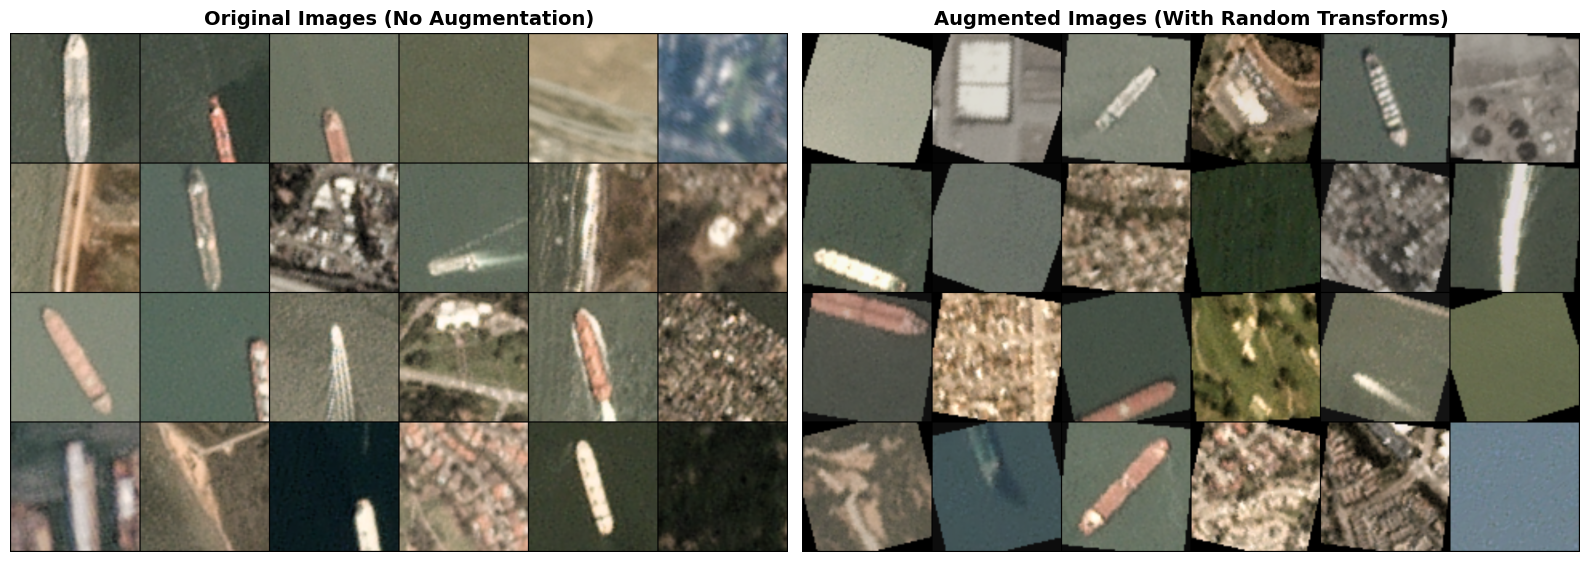

In [12]:
# functions to display a grid of images
def imshow_grid(img_batch, title, ax):
    # convert PyTorch tensor to NumPy array and rearrange dimensions
    # PyTorch: [C, H, W] will be converted to Matplotlib: [H, W, C]
    npimg = img_batch.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')

# get a batch from the original (no augmentation) dataset
test_dataiter = iter(test_dataloader)
test_images, test_labels = next(test_dataiter)

# get a batch from the augmented (training) dataset
train_dataiter = iter(train_dataloader)
train_images, train_labels = next(train_dataiter)

# reverse normalisation for visualisation
inv_test_images = inv_normalize(test_images)
inv_train_images = inv_normalize(train_images)

# clamp values to [0, 1] for matplotlib
inv_test_images = torch.clamp(inv_test_images, 0, 1)
inv_train_images = torch.clamp(inv_train_images, 0, 1)

# create a side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# show original images
imshow_grid(torchvision.utils.make_grid(inv_test_images[:24], nrow=6), 'Original Images (No Augmentation)', axes[0])

# show augmented images
imshow_grid(torchvision.utils.make_grid(inv_train_images[:24], nrow=6), 'Augmented Images (With Random Transforms)', axes[1])

plt.tight_layout()

# save figure to assets folder
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)
fig.savefig(os.path.join(assets_path, 'data_augmentation_comparison.png'), dpi=300)

# show plot
plt.show()

## 3. Prepare the Use of a Pre-Trained Model

In [13]:
# set up shared configurations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use GPU if available
num_classes=2 # binary classification: ship (1) vs no-ship (0)
feature_extract = True # freeze the pretrained layers (only train the final classifier)
learning_rate = 0.0005 # chosen learning rate for Adam optimiser
epochs = 30 # number of training epochs - set to 10 for computational concerns

# freeze all layers except the classifier if feature_extract is True
# it disables gradient computation for all parameters if feature_extracting is True
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [14]:
# define the training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train() # set the model to training mode
    size = len(dataloader.dataset) # total number of samples
    num_batches = len(dataloader) # total number of batches
    train_loss, train_correct = 0, 0 # initialise accumulators for loss and correct predictions

    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # move inputs and labels to GPU

        pred = model(X) # forward pass
        loss = loss_fn(pred, y) # compute loss between predictions and true labels

        optimizer.zero_grad() # clear previous gradients
        loss.backward() # backpropagation: compute gradients
        optimizer.step() # update model parameters

        train_loss += loss.item() # accumulate loss
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item() # accumulate correct predictions

        # print progress every 10 batches
        if batch_idx % 10 == 0:
          print(f" Batch {batch_idx}/{num_batches} - Loss: {loss.item():.4f}")

    # return average loss and accuracy over the training set
    return train_loss / num_batches, train_correct / size

# define the evaluation loop
def test_loop(dataloader, model, loss_fn):
    model.eval() # set model to evaluation mode
    size = len(dataloader.dataset) # total number of samples
    num_batches = len(dataloader) # total number of batches
    test_loss, test_correct = 0, 0 # initialise accumulators for loss and correct predictions

    with torch.no_grad(): # disable gradient computation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) # move inputs and labels to GPU

            pred = model(X) # forward pass
            test_loss += loss_fn(pred, y).item() # accumulate loss

            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item() # accumulate correct predictions

    # return average loss and accuracy over the evaluation set
    return test_loss / num_batches, test_correct / size

In [15]:
# unified training function to train a model and save results with early stopping
def run_model_training(name, model_fn, classifier_fn, save_dir, patience=5):
    print(f"\nTraining: {name}")  # display model name being trained

    # load a pre-trained model architecture
    model = model_fn(pretrained=True)
    # freeze feature extraction layers if required
    set_parameter_requires_grad(model, feature_extract)
    # replace the final classification layer
    classifier_fn(model)
    # move model to GPU
    model = model.to(device)

    # define optimizer (Adam) and loss function (CrossEntropyLoss for classification)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # initialise lists to store loss and accuracy values across epochs
    train_loss_array = []
    test_loss_array = []
    train_acc_array = []
    test_acc_array = []

    # initialize variables for early stopping
    best_test_loss = float('inf')  # best test loss observed so far
    epochs_no_improve = 0          # counter for epochs without improvement
    best_model_wts = None          # best model weights

    # training loop over all epochs
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # train the model for one epoch
        train_loss, train_acc = train_loop(train_dataloader, model, criterion, optimizer)
        # evaluate the model on the test set
        test_loss, test_acc = test_loop(test_dataloader, model, criterion)

        # display metrics
        print(f" Train Acc: {train_acc:.4f}, Loss: {train_loss:.4f}")
        print(f" Test  Acc: {test_acc:.4f}, Loss: {test_loss:.4f}")

        # record training/testing losses and accuracies
        train_loss_array.append(train_loss)
        test_loss_array.append(test_loss)
        train_acc_array.append(train_acc)
        test_acc_array.append(test_acc)

        # early stopping logic
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            best_model_wts = model.state_dict()  # save current best model weights
        else:
            epochs_no_improve += 1

        # stop training if no improvement for 'patience' epochs
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs.")
            break

    # after early stopping or training finishes, load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    # save model weights after training
    model_path = os.path.join(save_dir, f"{name}_model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Saved best model to {model_path}")

    # save recorded training statistics (loss and accuracy arrays)
    stats = {
        "train_loss": train_loss_array,
        "test_loss": test_loss_array,
        "train_acc": train_acc_array,
        "test_acc": test_acc_array
    }

    stats_path = os.path.join(save_dir, f"{name}_stats.pkl")
    with open(stats_path, "wb") as f:
        pickle.dump(stats, f)
    print(f"Saved stats to {stats_path}")

## 4. Fine-Tune with Training Data

In [62]:
# set output directory where trained models will be saved
output_dir = "/content/drive/MyDrive/GEOG0125/models"
os.makedirs(output_dir, exist_ok=True) # create directory if it doesn't already exist

# train VGG11 model
run_model_training(
    name="vgg11", # name identifier for saving model and stats
    model_fn=models.vgg11_bn, # load the VGG11 architecture with batch normalisation
    classifier_fn=lambda model: setattr(
        model.classifier, "6", nn.Linear(model.classifier[6].in_features, num_classes)
    ), # replace the final fully connected layer to match the number of output classes
    save_dir=output_dir # directory to save trained model and training statistics
)


Training: vgg11


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30
 Batch 0/134 - Loss: 0.7078
 Batch 10/134 - Loss: 0.5697
 Batch 20/134 - Loss: 0.3948
 Batch 30/134 - Loss: 0.3200
 Batch 40/134 - Loss: 0.2738
 Batch 50/134 - Loss: 0.3134
 Batch 60/134 - Loss: 0.2782
 Batch 70/134 - Loss: 0.1578
 Batch 80/134 - Loss: 0.2352
 Batch 90/134 - Loss: 0.1828
 Batch 100/134 - Loss: 0.2668
 Batch 110/134 - Loss: 0.4193
 Batch 120/134 - Loss: 0.5296
 Batch 130/134 - Loss: 0.2404
 Train Acc: 0.8322, Loss: 0.3610
 Test  Acc: 0.8862, Loss: 0.2805
Epoch 2/30
 Batch 0/134 - Loss: 0.2107
 Batch 10/134 - Loss: 0.2022
 Batch 20/134 - Loss: 0.2904
 Batch 30/134 - Loss: 0.2953
 Batch 40/134 - Loss: 0.0831
 Batch 50/134 - Loss: 0.2644
 Batch 60/134 - Loss: 0.2923
 Batch 70/134 - Loss: 0.2760
 Batch 80/134 - Loss: 0.2662
 Batch 90/134 - Loss: 0.3695
 Batch 100/134 - Loss: 0.1145
 Batch 110/134 - Loss: 0.2344
 Batch 120/134 - Loss: 0.2191
 Batch 130/134 - Loss: 0.1202
 Train Acc: 0.8722, Loss: 0.2885
 Test  Acc: 0.9025, Loss: 0.2365
Epoch 3/30
 Batch 0/134 - Lo

In [63]:
# train ResNet50 model
run_model_training(
    name="resnet50", # name identifier for saving model and stats
    model_fn=models.resnet50, # load the ResNet50 architecture with default pretrained weights
    classifier_fn=lambda model: setattr(
        model, "fc", nn.Linear(model.fc.in_features, num_classes)
    ), # replace the final fully connected layer ('fc') to match the number of output classes
    save_dir=output_dir # directory to save pretrained model and training statistics
)


Training: resnet50


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30
 Batch 0/134 - Loss: 0.5836
 Batch 10/134 - Loss: 0.4603
 Batch 20/134 - Loss: 0.6389
 Batch 30/134 - Loss: 0.3322
 Batch 40/134 - Loss: 0.2611
 Batch 50/134 - Loss: 0.4584
 Batch 60/134 - Loss: 0.3527
 Batch 70/134 - Loss: 0.4660
 Batch 80/134 - Loss: 0.3241
 Batch 90/134 - Loss: 0.3795
 Batch 100/134 - Loss: 0.3327
 Batch 110/134 - Loss: 0.2131
 Batch 120/134 - Loss: 0.1893
 Batch 130/134 - Loss: 0.2333
 Train Acc: 0.8228, Loss: 0.3910
 Test  Acc: 0.7863, Loss: 0.4396
Epoch 2/30
 Batch 0/134 - Loss: 0.3520
 Batch 10/134 - Loss: 0.2347
 Batch 20/134 - Loss: 0.2850
 Batch 30/134 - Loss: 0.2581
 Batch 40/134 - Loss: 0.1867
 Batch 50/134 - Loss: 0.4529
 Batch 60/134 - Loss: 0.2799
 Batch 70/134 - Loss: 0.3414
 Batch 80/134 - Loss: 0.2566
 Batch 90/134 - Loss: 0.1682
 Batch 100/134 - Loss: 0.2486
 Batch 110/134 - Loss: 0.1964
 Batch 120/134 - Loss: 0.2371
 Batch 130/134 - Loss: 0.4480
 Train Acc: 0.8741, Loss: 0.2900
 Test  Acc: 0.8550, Loss: 0.3260
Epoch 3/30
 Batch 0/134 - Lo

In [64]:
# train EfficientNet B0 model
run_model_training(
    name="efficientnet_b0", # name identifier for saving model and stats
    model_fn=models.efficientnet_b0, # load the EfficientNet B0 architecture with default pretrained weights
    classifier_fn=lambda model: setattr(
        model.classifier, "1", nn.Linear(model.classifier[1].in_features, num_classes)
    ), # replace the final fully connected layer (index 1 in classifier) to match the number of output classes
    save_dir=output_dir # directory to save trained model and training statistics
)


Training: efficientnet_b0
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 Batch 0/134 - Loss: 0.6767
 Batch 10/134 - Loss: 0.4980
 Batch 20/134 - Loss: 0.3509
 Batch 30/134 - Loss: 0.4336
 Batch 40/134 - Loss: 0.3349
 Batch 50/134 - Loss: 0.3980
 Batch 60/134 - Loss: 0.4226
 Batch 70/134 - Loss: 0.2957
 Batch 80/134 - Loss: 0.3078
 Batch 90/134 - Loss: 0.5533
 Batch 100/134 - Loss: 0.3870
 Batch 110/134 - Loss: 0.3168
 Batch 120/134 - Loss: 0.3587
 Batch 130/134 - Loss: 0.2437
 Train Acc: 0.8134, Loss: 0.4127
 Test  Acc: 0.8287, Loss: 0.3784
Epoch 2/30
 Batch 0/134 - Loss: 0.1926
 Batch 10/134 - Loss: 0.2069
 Batch 20/134 - Loss: 0.3383
 Batch 30/134 - Loss: 0.2850
 Batch 40/134 - Loss: 0.4353
 Batch 50/134 - Loss: 0.3516
 Batch 60/134 - Loss: 0.2719
 Batch 70/134 - Loss: 0.2521
 Batch 80/134 - Loss: 0.3177
 Batch 90/134 - Loss: 0.2096
 Batch 100/134 - Loss: 0.2030
 Batch 110/134 - Loss: 0.3150
 Batch 120/134 - Loss: 0.1599
 Batch 130/134 - Loss: 0.2636
 Train Acc: 0.8731, Loss: 0.3018
 Test  Acc: 0.8137, Loss: 0.4085
Epoch 3/30
 Batch 0/134 - Loss: 0.3217


In [16]:
# function to reload a trained model for evaluation or further analysis
def load_trained_model(model_name, model_path, num_classes=2, device=None):
    # if no device is specified, default to GPU if available
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # select model architecture
    if model_name == "vgg11":
        model = models.vgg11_bn(pretrained=False)
        num_ftrs = model.classifier[6].in_features # get number of features from the final classifier layer
        model.classifier[6] = nn.Linear(num_ftrs, num_classes) # replace final layer to match number of output classes

    elif model_name == "resnet50":
        model = models.resnet50(pretrained=False)
        num_ftrs = model.fc.in_features # get number of features from the fully connected layer
        model.fc = nn.Linear(num_ftrs, num_classes) # replace final layer to match number of output classes

    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=False)
        num_ftrs = model.classifier[1].in_features # get number of features from the final classifier layer
        model.classifier[1] = nn.Linear(num_ftrs, num_classes) # replace final layer to match number of output classes

    else:
        # raise an error if an unsupported model name is provided
        raise ValueError(f"Unsupported model name: {model_name}")

    # load the saved model weights from the specified file
    model.load_state_dict(torch.load(model_path, map_location=device))
    # move the model to the appropriate device
    model.to(device)
    # set model to evaluation mode
    model.eval()
    print(f"Loaded {model_name} from {model_path}")
    return model

# function to reload training statistics (losses, accuracies) from a pickle file
def load_training_stats(stats_path):
    with open(stats_path, 'rb') as f:
        stats = pickle.load(f)
    print(f"Training stats loaded from {stats_path}")
    return stats

In [17]:
# re-import the models module from torchvision
from torchvision import models

# define models and corresponding paths
model_info = {
    "vgg11": {
        "path": "/content/drive/MyDrive/GEOG0125/models/vgg11_model.pth", # saved VGG11 model weights
        "stats": "/content/drive/MyDrive/GEOG0125/models/vgg11_stats.pkl" # saved VGG11 training statistics
    },
    "resnet50": {
        "path": "/content/drive/MyDrive/GEOG0125/models/resnet50_model.pth", # saved ResNet50 model weights
        "stats": "/content/drive/MyDrive/GEOG0125/models/resnet50_stats.pkl" # saved ResNet50 training statistics
    },
    "efficientnet_b0": {
        "path": "/content/drive/MyDrive/GEOG0125/models/efficientnet_b0_model.pth", # saved EfficientNet B0 model weights
        "stats": "/content/drive/MyDrive/GEOG0125/models/efficientnet_b0_stats.pkl" # saved EfficientNet B0 training statistics
    }
}

# initialise empty dictionaries to store loaded models and corresponding training stats
loaded_models = {}
stats = {}

# iterate over each model and its paths
for model_name, paths in model_info.items():
    # load the trained model architecture with weights
    loaded_models[model_name] = load_trained_model(model_name, paths["path"])
    # load the recorded training statistics (loss and accuracy per epoch)
    stats[model_name] = load_training_stats(paths["stats"])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded vgg11 from /content/drive/MyDrive/GEOG0125/models/vgg11_model.pth
Training stats loaded from /content/drive/MyDrive/GEOG0125/models/vgg11_stats.pkl
Loaded resnet50 from /content/drive/MyDrive/GEOG0125/models/resnet50_model.pth
Training stats loaded from /content/drive/MyDrive/GEOG0125/models/resnet50_stats.pkl
Loaded efficientnet_b0 from /content/drive/MyDrive/GEOG0125/models/efficientnet_b0_model.pth
Training stats loaded from /content/drive/MyDrive/GEOG0125/models/efficientnet_b0_stats.pkl


In [18]:
# select the loaded VGG11 model from the models dictionary
vgg_model = loaded_models["vgg11"]
# extract the saved training and testing loss/accuracy arrays for VGG11
vgg_train_loss = stats["vgg11"]['train_loss'] # training loss recorded across epochs
vgg_test_loss = stats["vgg11"]['test_loss']   # test loss recorded across epochs
vgg_train_acc = stats["vgg11"]['train_acc']   # training accuracy recorded across epochs
vgg_test_acc = stats["vgg11"]['test_acc']     # test accuracy recorded across epochs

In [19]:
# select the loaded ResNet50 model from the models dictionary
resnet_model = loaded_models["resnet50"]
# extract the saved training and testing loss/accuracy arrays for ResNet50
resnet_train_loss = stats["resnet50"]['train_loss'] # training loss recorded across epoch
resnet_test_loss = stats["resnet50"]['test_loss']   # test loss recorded across epochs
resnet_train_acc = stats["resnet50"]['train_acc']   # training accuracy recorded across epochs
resnet_test_acc = stats["resnet50"]['test_acc']     # test accuracy recorded across epochs

In [20]:
# select the loaded EfficientNet_B0 model from the models dictionary
effnet_model = loaded_models["efficientnet_b0"]
# extract the saved training and testing loss/accuracy arrays for EfficientNet_B0
effnet_train_loss = stats["efficientnet_b0"]['train_loss'] # training loss recorded across epoch
effnet_test_loss = stats["efficientnet_b0"]['test_loss']   # test loss recorded across epochs
effnet_train_acc = stats["efficientnet_b0"]['train_acc']   # training accuracy recorded across epochs
effnet_test_acc = stats["efficientnet_b0"]['test_acc']     # test accuracy recorded across epochs

## 5. Evaluation Metrics

## 5.1. VGG11

minimal test loss: 0.13611078262329102


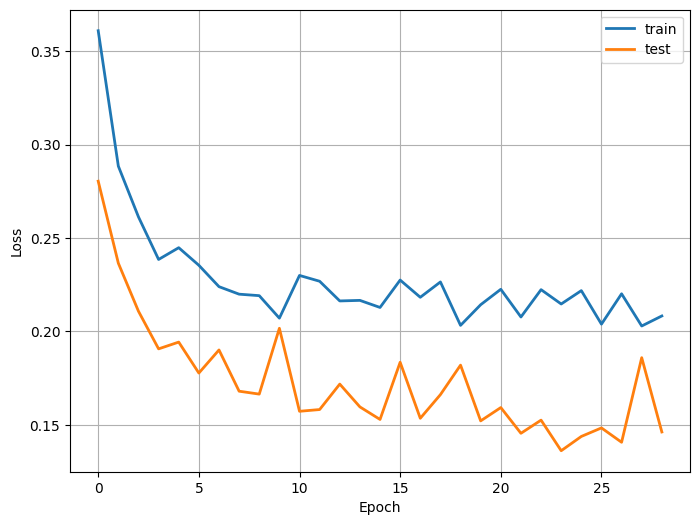

In [21]:
# combine training and test loss into a table
loss_array = zip(vgg_train_loss, vgg_test_loss) # pairs (train_loss, test_loss) for each epoch
loss_df = pd.DataFrame(loss_array,columns=['train','test']) # create a DataFrame for plotting

# plot loss over epochs
ax = loss_df.plot(figsize=(8, 6), linewidth=2)
# plt.title('Loss per Epoch', fontsize=12, fontweight = 'bold')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)

# save figure to Drive
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
plt.savefig(os.path.join(assets_path, 'vgg11_loss_curve.png'), dpi=300)

# print the minimum test loss value
print('minimal test loss: ' + str(np.min(vgg_test_loss)))

maximum test accuracy:0.95


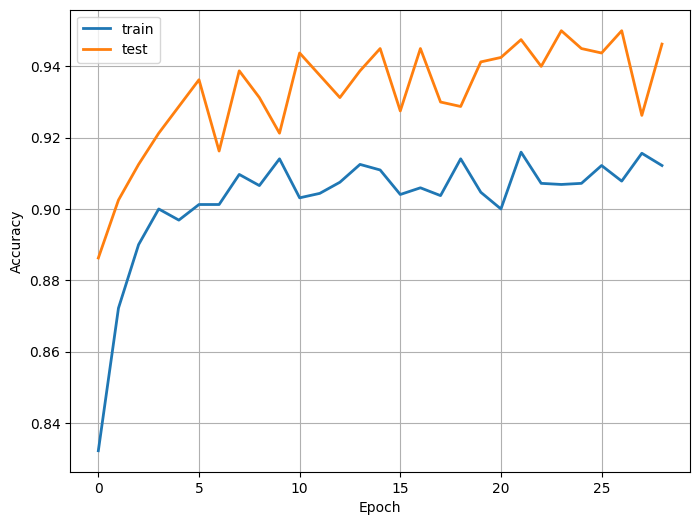

In [22]:
# combine training and test accuracy into a table
acc_array = zip(vgg_train_acc, vgg_test_acc) # pairs (train_acc, test_acc) for each epoch
acc_df = pd.DataFrame(acc_array,columns=['train','test']) # create a DataFrame for plotting

# plot accuracy over epochs
ax = acc_df.plot(figsize=(8, 6), linewidth=2)
# plt.title('Accuracy per Epoch', fontsize=12, fontweight = 'bold')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)

# save figure to Drive
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
plt.savefig(os.path.join(assets_path, 'vgg11_accuracy_curve.png'), dpi=300)

# print the highest accuracy achieved
print('maximum test accuracy:' + str(np.max(vgg_test_acc)))

              precision    recall  f1-score   support

     no-ship       0.98      0.95      0.96       600
        ship       0.86      0.94      0.90       200

    accuracy                           0.95       800
   macro avg       0.92      0.94      0.93       800
weighted avg       0.95      0.95      0.95       800



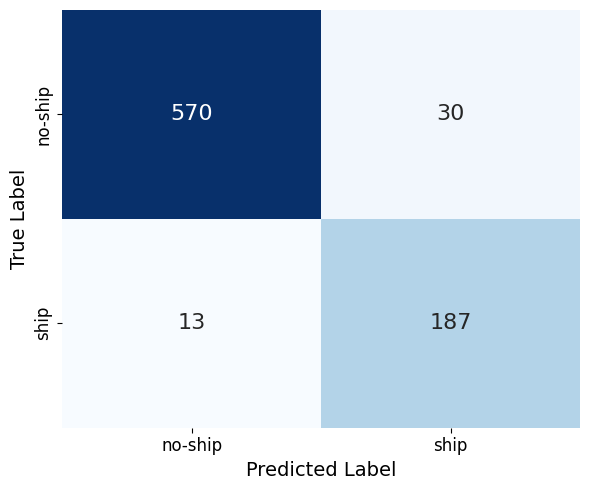

In [46]:
# get all predictions and true labels
all_preds = []
all_labels = []

vgg_model.eval()  # set model to eval mode
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        outputs = vgg_model(X)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# print detailed classification metrics
print(classification_report(all_labels, all_preds, target_names=["no-ship", "ship"]))

# we have high overall accuracy of 95% - this shows that the fine-tuned VGG11 model generalises well to unseen data
# ship recall is very high at 94%, meaning the model correctly identifies most ships, which is what we want in a detection task
# ship precision is 86%, meaning that some non-ship chips are incorrectly classified as ships (false positives)
# 13 Falsse Negatives and 30 False Positives - the model tends to overpredict "ship" slightly more than missing them (often better in detection tasks - better to review more candidates than to miss actual ships)
# the model's training and validation accuracies are quire close (around 91-95%), without too much divergence
# early stopping trigger after 29 epochs, preventing overfitting

# use actual predictions and labels
y_true = all_labels
y_pred = all_preds

# get confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['no-ship', 'ship']

# plot confusion matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

# update font size of annotations
for text in ax.texts:
    text.set_fontsize(16)

ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
# plt.title('Confusion Matrix')
plt.tight_layout()

# save confusion matrix figure
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)
plt.savefig(os.path.join(assets_path, 'vgg11_confusion_matrix.png'), dpi=300)

# show plot
plt.show()

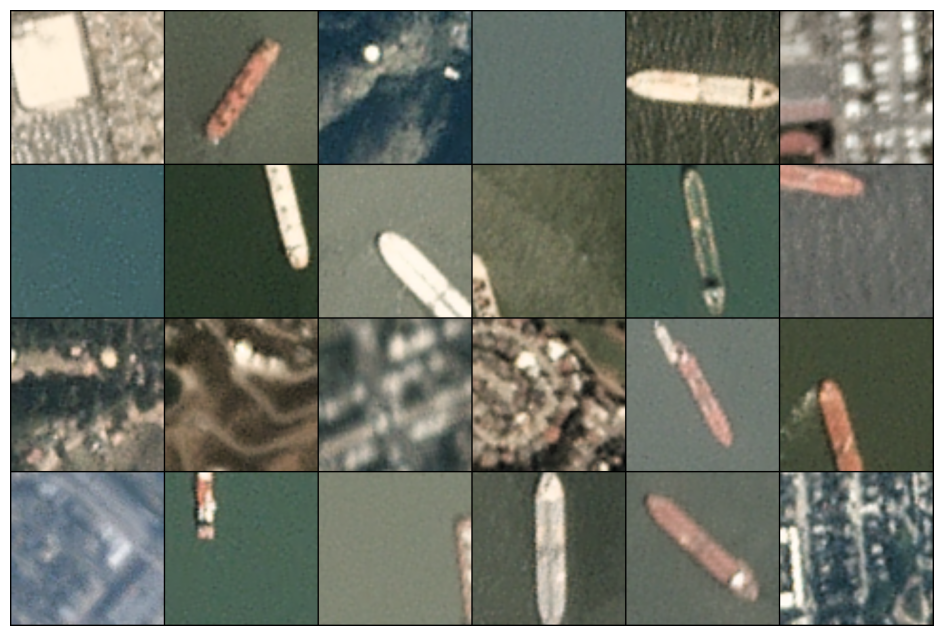

    True Label  Predicted Label
0            0                0
1            1                1
2            0                0
3            0                0
4            1                1
5            0                0
6            0                0
7            0                0
8            0                0
9            0                0
10           1                1
11           0                0
12           0                0
13           0                0
14           0                0
15           0                0
16           1                1
17           0                1
18           0                0
19           0                0
20           0                0
21           1                1
22           1                1
23           0                0

number of correct predictions: 23
number of incorrect predictions: 1


In [27]:
# functions to display a grid of images
def imshow_grid(img_batch, ax=None):
    npimg = img_batch.numpy()
    if ax is None:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
    else:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.axis('off')

# get a batch of test images and corresponding labels
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# move images to device
images = images.to(device)

# predict with the model
vgg_model.eval()
with torch.no_grad():
    pred = vgg_model(images)

# reverse the normalisation so the images look correct
inv_images = inv_normalize(images.cpu())
inv_images = torch.clamp(inv_images, 0, 1)

# create figure first
fig, ax = plt.subplots(figsize=(16, 8))
imshow_grid(torchvision.utils.make_grid(inv_images[:24], nrow=6), ax=ax)

# save the image grid
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)
fig.savefig(os.path.join(assets_path, 'vgg11_sample_predictions.png'), dpi=300)
plt.show()

# convert predictions and labels to NumPy arrays
y_obs = labels.numpy()
y_pred = np.argmax(pred.cpu().numpy(), axis=1)

# build a comparison table
comparison_df = pd.DataFrame({
    'True Label': y_obs,
    'Predicted Label': y_pred
})

# display the table nicely
print(comparison_df)

# print overall correctness
correct = np.sum(y_obs == y_pred)
incorrect = np.sum(y_obs != y_pred)

print(f'\nnumber of correct predictions: {correct}')
print(f'number of incorrect predictions: {incorrect}')

# save the label-prediction table
comparison_df.to_csv(os.path.join(assets_path, 'vgg11_prediction_labels_table.csv'), index=False)

## 5.2. ResNet50

minimal test loss: 0.19002334203790217


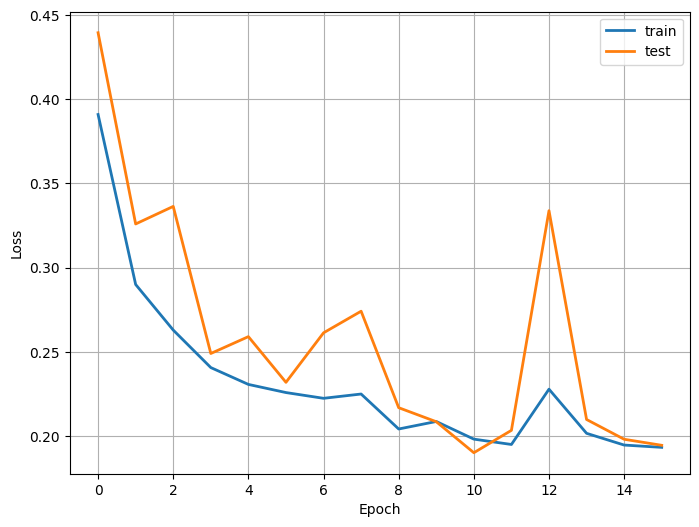

In [28]:
# combine training and test loss into a table
loss_array = zip(resnet_train_loss, resnet_test_loss)  # pairs (train_loss, test_loss) for each epoch
loss_df = pd.DataFrame(loss_array, columns=['train', 'test'])  # create a DataFrame for plotting

# plot loss over epochs
ax = loss_df.plot(figsize=(8, 6), linewidth=2)
# plt.title('Loss per Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)

# save figure to Drive
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)
plt.savefig(os.path.join(assets_path, 'resnet50_loss_curve.png'), dpi=300)

# print the minimum test loss value
print('minimal test loss: ' + str(np.min(resnet_test_loss)))

maximum test accuracy: 0.92


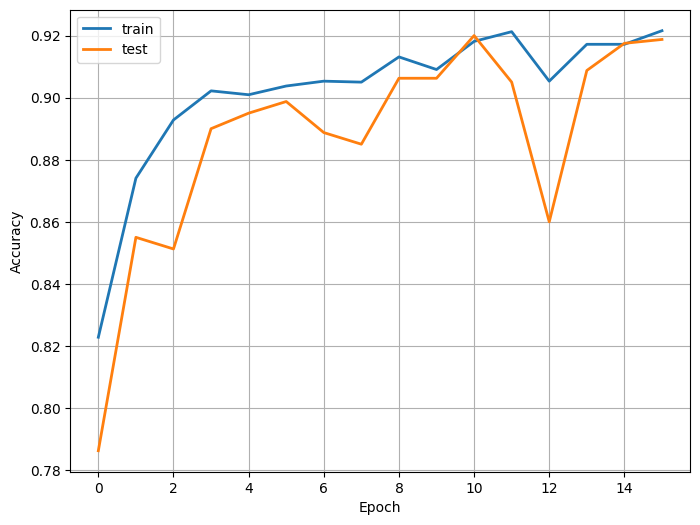

In [29]:
# combine training and test accuracy into a table
acc_array = zip(resnet_train_acc, resnet_test_acc)  # pairs (train_acc, test_acc) for each epoch
acc_df = pd.DataFrame(acc_array, columns=['train', 'test'])  # create a DataFrame for plotting

# plot accuracy over epochs
ax = acc_df.plot(figsize=(8, 6), linewidth=2)
# plt.title('Accuracy per Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)

# save figure to Drive
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)
plt.savefig(os.path.join(assets_path, 'resnet50_accuracy_curve.png'), dpi=300)

# print the highest accuracy achieved
print('maximum test accuracy: ' + str(np.max(resnet_test_acc)))

              precision    recall  f1-score   support

     no-ship       0.97      0.92      0.94       600
        ship       0.79      0.92      0.85       200

    accuracy                           0.92       800
   macro avg       0.88      0.92      0.90       800
weighted avg       0.93      0.92      0.92       800



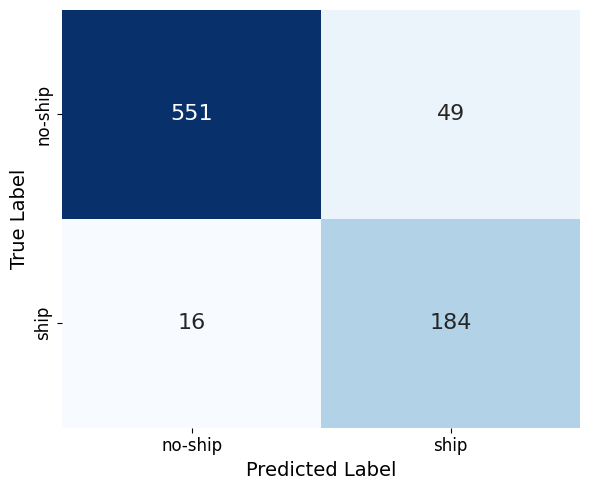

In [47]:
# get all predictions and true labels
all_preds = []
all_labels = []

resnet_model.eval()  # set model to eval mode
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        outputs = resnet_model(X)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# print detailed classification metrics
print(classification_report(all_labels, all_preds, target_names=["no-ship", "ship"]))

# we have an overall accuracy of 92% – showing that the fine-tuned ResNet50 model generalises well to unseen test data
# ship recall is very high at 92%, meaning the model correctly identifies most ships, which is crucial in detection tasks
# ship precision is 79%, slightly lower than VGG11, indicating the model produces more false positives (classifying non-ship chips as ships)
# 16 False Negatives and 49 False Positives – the model overpredicts ships slightly, which is often preferable for detection tasks (better to review false alarms than miss real ships)
# the model's training and validation accuracies are reasonably close (~91–92%), indicating good generalisation without significant overfitting
# early stopping was triggered after 16 epochs, ensuring efficient training and preventing overfitting

# use actual predictions and labels
y_true = all_labels
y_pred = all_preds

# get confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['no-ship', 'ship']

# plot confusion matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

# ㅕpdate font size of annotations
for text in ax.texts:
    text.set_fontsize(16)

ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
# plt.title('Confusion Matrix')
plt.tight_layout()

# save confusion matrix figure
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)
plt.savefig(os.path.join(assets_path, 'resnet50_confusion_matrix.png'), dpi=300)

# show plot
plt.show()

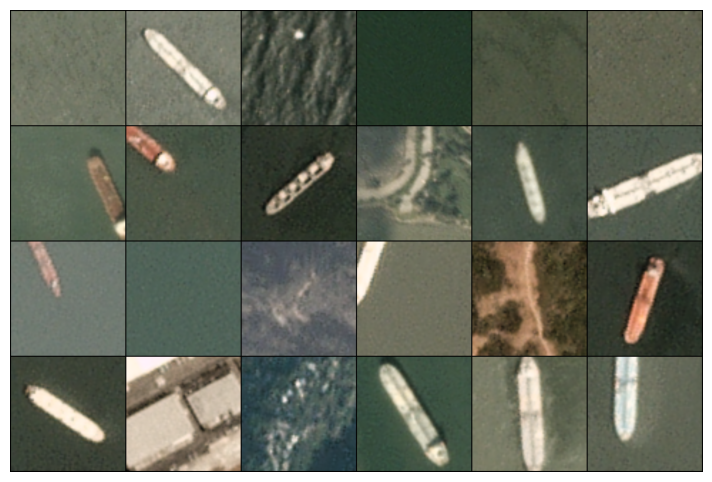

    True Label  Predicted Label
0            0                0
1            1                1
2            0                0
3            0                0
4            0                0
5            0                0
6            0                0
7            0                0
8            1                1
9            0                0
10           1                1
11           1                1
12           0                1
13           0                0
14           0                0
15           0                0
16           0                0
17           1                1
18           1                1
19           0                0
20           0                0
21           1                1
22           1                1
23           0                1

number of correct predictions: 22
number of incorrect predictions: 2


In [51]:
# function to display a grid of images
def imshow_grid(img_batch, ax=None, title=None):
    npimg = img_batch.numpy()
    if ax is None:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
        if title:
            plt.title(title, fontsize=14, fontweight='bold')
    else:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.axis('off')
        if title:
            ax.set_title(title, fontsize=14, fontweight='bold')

# get a batch of test images and corresponding labels
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# move images to device
images = images.to(device)

# set model to evaluation mode
resnet_model.eval()

# predict with the model
with torch.no_grad():
    pred = resnet_model(images)

# reverse the normalisation
inv_images = inv_normalize(images.cpu())
inv_images = torch.clamp(inv_images, 0, 1)  # clamp to [0,1] for matplotlib

# create figure
fig, ax = plt.subplots(figsize=(12, 6))
imshow_grid(torchvision.utils.make_grid(inv_images[:24], nrow=6), ax=ax)

# save figure to assets folder
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)
fig.savefig(os.path.join(assets_path, 'resnet50_sample_predictions.png'), dpi=300)

# show the plot
plt.show()

# convert predictions and labels to NumPy arrays
y_obs = labels.numpy()
y_pred = np.argmax(pred.cpu().numpy(), axis=1)

# build a table of true and predicted labels
df = pd.DataFrame({
    'True Label': y_obs,
    'Predicted Label': y_pred
})

# show table
print(df)

# summary counts
print(f'\nnumber of correct predictions: {np.sum(y_obs == y_pred)}')
print(f'number of incorrect predictions: {np.sum(y_obs != y_pred)}')

# save the label-prediction table
df.to_csv(os.path.join(assets_path, 'resnet50_prediction_labels_table.csv'), index=False)

## 5.3. EfficientNet_B0

minimal test loss: 0.2643912410473122


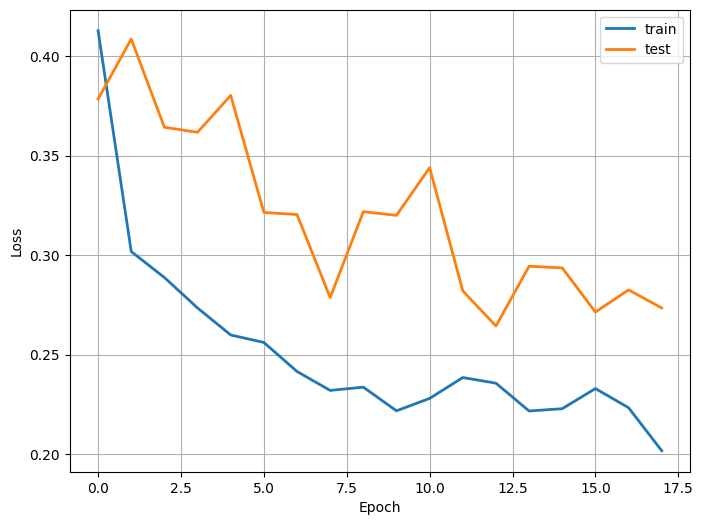

In [84]:
# combine training and test loss into a table
loss_array = zip(effnet_train_loss, effnet_test_loss)  # pairs (train_loss, test_loss) for each epoch
loss_df = pd.DataFrame(loss_array, columns=['train', 'test'])  # create a DataFrame for plotting

# plot loss over epochs
ax = loss_df.plot(figsize=(8, 6), linewidth=2)
# plt.title('Loss per Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)

# save figure to Drive
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)
plt.savefig(os.path.join(assets_path, 'efficientnet_b0_loss_curve.png'), dpi=300)

# print the minimum test loss value
print('minimal test loss: ' + str(np.min(effnet_test_loss)))

maximum test accuracy: 0.8825


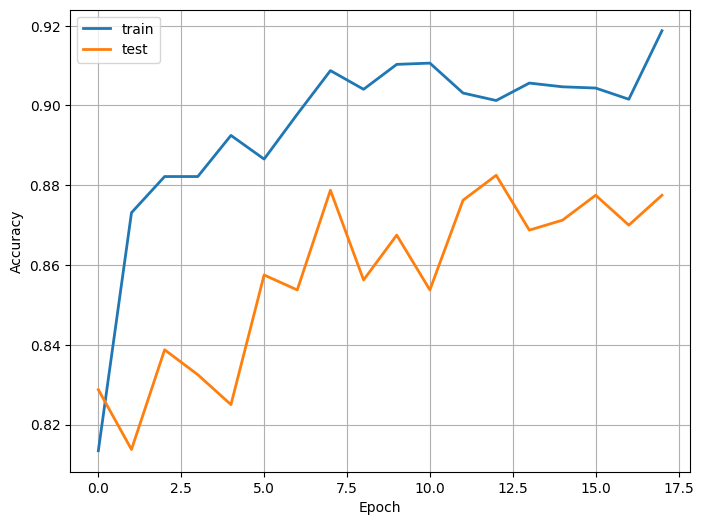

In [85]:
# combine training and test accuracy into a table
acc_array = zip(effnet_train_acc, effnet_test_acc)  # pairs (train_acc, test_acc) for each epoch
acc_df = pd.DataFrame(acc_array, columns=['train', 'test'])  # create a DataFrame for plotting

# plot accuracy over epochs
ax = acc_df.plot(figsize=(8, 6), linewidth=2)
# plt.title('Accuracy per Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)

# save figure to Drive
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)
plt.savefig(os.path.join(assets_path, 'efficientnet_b0_accuracy_curve.png'), dpi=300)

# print the highest accuracy achieved
print('maximum test accuracy: ' + str(np.max(effnet_test_acc)))

              precision    recall  f1-score   support

     no-ship       0.98      0.86      0.91       600
        ship       0.69      0.94      0.79       200

    accuracy                           0.88       800
   macro avg       0.83      0.90      0.85       800
weighted avg       0.90      0.88      0.88       800



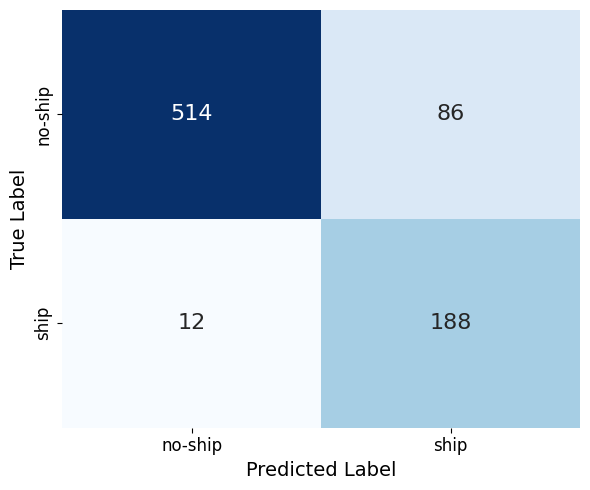

In [48]:
# get all predictions and true labels
all_preds = []
all_labels = []

effnet_model.eval()  # set model to eval mode
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        outputs = effnet_model(X)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# print detailed classification metrics
print(classification_report(all_labels, all_preds, target_names=["no-ship", "ship"]))

# we have an overall accuracy of 88% – showing that the fine-tuned EfficientNet-B0 model generalises reasonably well to unseen test data
# ship recall is very high at 94%, meaning the model detects most ships successfully, which is essential for detection tasks
# ship precision is lower at 69%, indicating a notable number of false positives (predicting "ship" when it's actually "no-ship")
# 12 False Negatives and 86 False Positives – the model tends to overpredict "ship" quite strongly, favoring sensitivity over specificity
# the model's training and validation accuracies are close (~91–88%), suggesting some mild overfitting but still acceptable generalisation
# early stopping triggered after 18 epochs, helping to avoid severe overfitting

# use actual predictions and labels
y_true = all_labels
y_pred = all_preds

# get confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['no-ship', 'ship']

# plot confusion matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

# update font size of annotations
for text in ax.texts:
    text.set_fontsize(16)

ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
# plt.title('Confusion Matrix')
plt.tight_layout()

# save confusion matrix figure
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)
plt.savefig(os.path.join(assets_path, 'efficientnet_confusion_matrix.png'), dpi=300)

# show plot
plt.show()

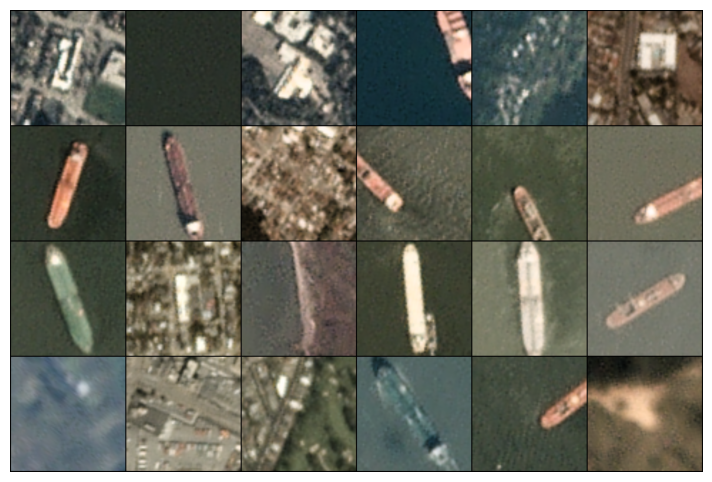

    True Label  Predicted Label
0            0                0
1            0                0
2            0                0
3            0                0
4            0                0
5            0                0
6            1                1
7            1                1
8            0                0
9            0                0
10           0                0
11           0                1
12           1                1
13           0                0
14           0                0
15           1                1
16           1                0
17           1                1
18           0                0
19           0                0
20           0                0
21           1                0
22           0                1
23           0                0

number of correct predictions: 20
number of incorrect predictions: 4


In [52]:
# function to display a grid of images
def imshow_grid(img_batch, ax=None, title=None):
    npimg = img_batch.numpy()
    if ax is None:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
        if title:
            plt.title(title, fontsize=14, fontweight='bold')
    else:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.axis('off')
        if title:
            ax.set_title(title, fontsize=14, fontweight='bold')

# get a batch of test images and corresponding labels
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# move images to device
images = images.to(device)

# set model to evaluation mode
effnet_model.eval()

# predict with the model
with torch.no_grad():
    pred = effnet_model(images)

# reverse the normalisation
inv_images = inv_normalize(images.cpu())
inv_images = torch.clamp(inv_images, 0, 1)  # clamp to [0,1] for matplotlib

# create figure
fig, ax = plt.subplots(figsize=(12, 6))
imshow_grid(torchvision.utils.make_grid(inv_images[:24], nrow=6), ax=ax)

# save figure to assets folder
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)
fig.savefig(os.path.join(assets_path, 'effnet_b0_sample_predictions.png'), dpi=300)

# show the plot
plt.show()

# convert predictions and labels to NumPy arrays
y_obs = labels.numpy()
y_pred = np.argmax(pred.cpu().numpy(), axis=1)

# build a table of true and predicted labels
df = pd.DataFrame({
    'True Label': y_obs,
    'Predicted Label': y_pred
})

# show table
print(df)

# summary counts
print(f'\nnumber of correct predictions: {np.sum(y_obs == y_pred)}')
print(f'number of incorrect predictions: {np.sum(y_obs != y_pred)}')

# save the label-prediction table
df.to_csv(os.path.join(assets_path, 'effnet_b0_prediction_labels_table.csv'), index=False)

## 6. Visual Explanations


Occlusion Attribution for VGG11


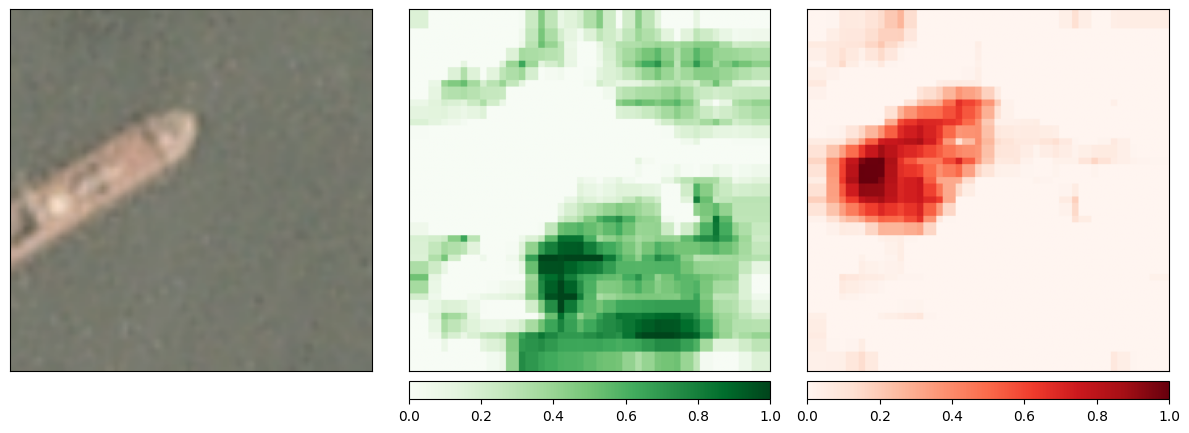

Saved attribution map to /content/drive/MyDrive/GEOG0125/assets/VGG11_occlusion.png


<Figure size 640x480 with 0 Axes>


Occlusion Attribution for ResNet50


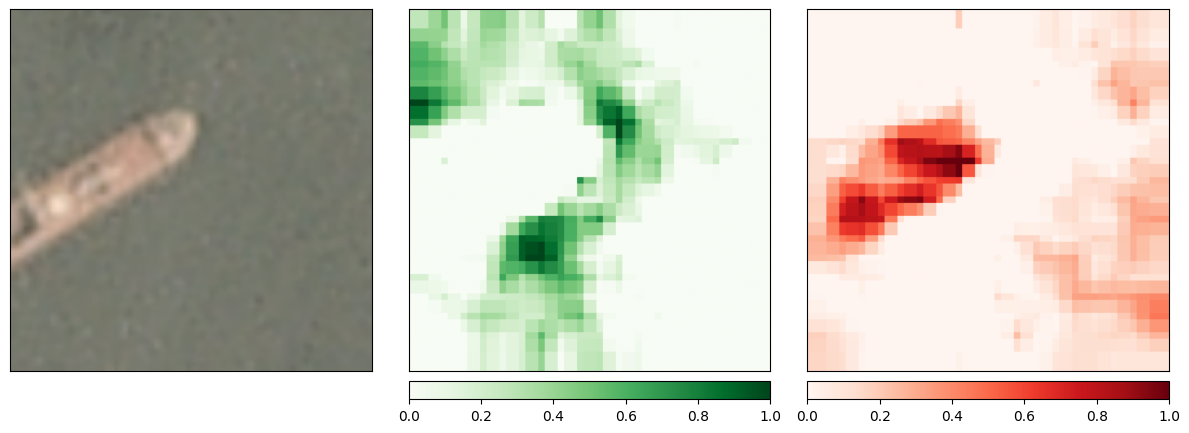

Saved attribution map to /content/drive/MyDrive/GEOG0125/assets/ResNet50_occlusion.png


<Figure size 640x480 with 0 Axes>


Occlusion Attribution for EfficientNet_B0


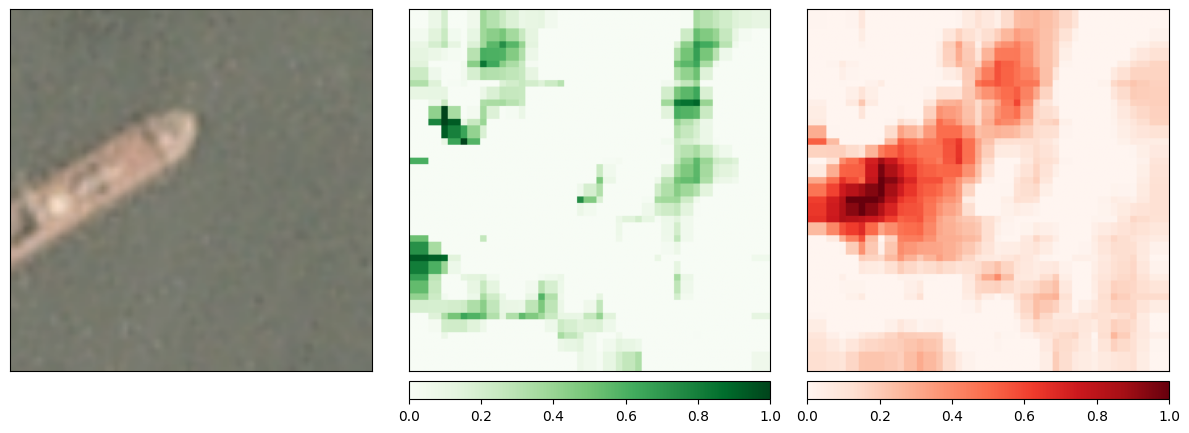

Saved attribution map to /content/drive/MyDrive/GEOG0125/assets/EfficientNet_B0_occlusion.png


<Figure size 640x480 with 0 Axes>

In [29]:
# path to save attributions
assets_path = '/content/drive/MyDrive/GEOG0125/assets/'
os.makedirs(assets_path, exist_ok=True)

# define models and their display names
model_list = {
    "VGG11": vgg_model,
    "ResNet50": resnet_model,
    "EfficientNet_B0": effnet_model
}

# get one batch of test images and labels
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# move the whole batch to GPU (if using GPU)
images = images.to(device)
labels = labels.to(device)

# use the first image in the batch
k = 0
input_img = images[k].unsqueeze(0)  # add batch dimension
target_class = labels[k].unsqueeze(0)

# loop through each model
for model_name, model in model_list.items():
    print(f"\nOcclusion Attribution for {model_name}")

    # set model to evaluation mode
    model.eval()

    # initialise Captum Occlusion explainer
    occlusion = Occlusion(model)

    # compute occlusion attributions
    attributions_occ = occlusion.attribute(
        input_img,
        strides=(3, 12, 12),
        sliding_window_shapes=(3, 20, 20),
        target=target_class,
        baselines=0
    )

    # reverse normalisation
    original_img = inv_normalize(images[k]).cpu().detach().numpy()
    original_img = np.transpose(original_img, (1, 2, 0))
    original_img = (original_img * 255.0).clip(0, 255).astype(np.uint8)

    # attribution map
    attr_np = attributions_occ.squeeze().cpu().detach().numpy()
    attr_np = np.transpose(attr_np, (1, 2, 0))

    # visualise
    _ = viz.visualize_image_attr_multiple(
        attr_np,
        original_img,
        methods=["original_image", "heat_map", "heat_map"],
        signs=["all", "positive", "negative"],
        show_colorbar=True,
        outlier_perc=2,
        fig_size=(12, 8)
    )

    plt.suptitle(f"{model_name} - Occlusion Attribution", fontsize=16, fontweight='bold')
    plt.tight_layout()

    # save figure to the assets folder
    save_path = os.path.join(assets_path, f"{model_name}_occlusion.png")
    plt.savefig(save_path, dpi=300)
    print(f"Saved attribution map to {save_path}")

    # show plot
    plt.show()

## 7. Ship Detection in Satellite Images Using Fine-Tuned Model

In [30]:
# define image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize([0.485, 0.456, 0.406], # ImageNet mean
                         [0.229, 0.224, 0.225]) # ImageNet std
])

In [31]:
# define sliding window function
def sliding_window(image, step = 20, window_size=(80, 80)):
  for y in range(0, image.shape[0] - window_size[1], step):
    for x in range(0, image.shape[1] - window_size[0], step):
      yield (x, y, image[y:y + window_size[0], x:x + window_size[0]])

In [32]:
from torchvision.ops import nms

# define detection function for scanning a full satellite scene
# iou_threshold controls overlap allowance in NMS
def detect_ships_in_image(model, scene_path, output_path, batch_size=32, confidence_threshold=0.95, iou_threshold=0.1):
  model.eval()  # set to evaluation mode
  # open the satellite image and convert it to RGB
  scene = Image.open(scene_path).convert("RGB")

  # convert the image to a NumPy array for processing
  scene_np = np.array(scene)

  # store coordinates, bounding boxes, and probabilities
  chips = []
  coords = []
  boxes = []
  scores = []

  # slide an 80x80 window over the image with a step of 10 pixels
  for (x, y, chip) in sliding_window(scene_np, step=10, window_size=(80, 80)):
    chip_tensor = transform(Image.fromarray(chip))
    chips.append(chip_tensor)
    coords.append((x, y))

    if len(chips) == batch_size:
      inputs = torch.stack(chips).to(device)
      with torch.no_grad():
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)[:, 1].cpu()
      for i, prob in enumerate(probs):
        if prob > confidence_threshold:
          x1, y1 = coords[i]
          x2, y2 = x1 + 80, y1 + 80
          boxes.append([x1, y1, x2, y2])
          scores.append(prob.item())
      chips, coords = [], []

  # process any remaining chips
  if chips:
    inputs = torch.stack(chips).to(device)
    with torch.no_grad():
      outputs = model(inputs)
      probs = F.softmax(outputs, dim=1)[:, 1].cpu()
    for i, prob in enumerate(probs):
      if prob > confidence_threshold:
        x1, y1 = coords[i]
        x2, y2 = x1 + 80, y1 + 80
        boxes.append([x1, y1, x2, y2])
        scores.append(prob.item())

  # apply non-maximum suppression to reduce overlapping detections
  if boxes:
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores)
    keep_indices = nms(boxes_tensor, scores_tensor, iou_threshold)
    boxes = boxes_tensor[keep_indices].int().tolist()
  else:
    boxes = []

  # draw bounding boxes on the image
  annotated = scene_np.copy()
  for (x1, y1, x2, y2) in boxes:
    cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)

  # save annotated image
  Image.fromarray(annotated).save(output_path)

  # summary
  print(f"{len(boxes)} ships detected in {os.path.basename(scene_path)}")
  display(IPyImage(output_path))

In [33]:
scene_dir = "/content/drive/MyDrive/GEOG0125/scenes"
output_dir = os.path.join(scene_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)

scene_files = [f for f in os.listdir(scene_dir) if f.endswith('.png')]

for model_name, model in loaded_models.items():
    print(f"\nRunning detection using {model_name.upper()}...\n")
    model_output_dir = os.path.join(output_dir, model_name)
    os.makedirs(model_output_dir, exist_ok=True)

    for fname in scene_files:
        input_path = os.path.join(scene_dir, fname)
        output_path = os.path.join(model_output_dir, f"detection_{fname}")
        print("Detecting in:", fname)
        detect_ships_in_image(model, input_path, output_path)

print("Check the 'outputs' folder in your scenes directory.")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# if interested in only VGG11 outputs
for fname in scene_files:
    input_path = os.path.join(scene_dir, fname)
    output_path = os.path.join(model_output_dir, f"detection_{fname}")
    print("Detecting in:", fname)
    detect_ships_in_image(vgg_model, input_path, output_path)

In [ ]:
# if interested in only ResNet50 outputs
for fname in scene_files:
    input_path = os.path.join(scene_dir, fname)
    output_path = os.path.join(model_output_dir, f"detection_{fname}")
    print("Detecting in:", fname)
    detect_ships_in_image(resnet_model, input_path, output_path)

In [ ]:
# if interested in only EfficientNet_B0 outputs
for fname in scene_files:
    input_path = os.path.join(scene_dir, fname)
    output_path = os.path.join(model_output_dir, f"detection_{fname}")
    print("Detecting in:", fname)
    detect_ships_in_image(effnet_model, input_path, output_path)

In [37]:
# confidence heatmap
def generate_confidence_heatmap(scene_path, model, transform, window_size=(80, 80), step=10, title=None, save_path=None):
    model.eval()
    scene = Image.open(scene_path).convert("RGB")
    scene_np = np.array(scene)
    h, w, _ = scene_np.shape

    # initialise heatmap
    heatmap = np.zeros((h, w), dtype=np.float32)
    count_map = np.zeros((h, w), dtype=np.int32)  # to average overlapping pixels

    for y in range(0, h - window_size[1], step):
        for x in range(0, w - window_size[0], step):
            chip = scene_np[y:y + window_size[1], x:x + window_size[0]]
            chip_tensor = transform(Image.fromarray(chip)).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(chip_tensor)
                prob = F.softmax(output, dim=1)[0, 1].item()  # prob of 'ship'

            # spread probability across heatmap for this window
            heatmap[y:y + window_size[1], x:x + window_size[0]] += prob
            count_map[y:y + window_size[1], x:x + window_size[0]] += 1

    # average the overlapping regions
    heatmap /= np.maximum(count_map, 1)

    # normalise to [0, 255] for visualisation
    norm_heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    color_map = cv2.applyColorMap(norm_heatmap, cv2.COLORMAP_JET)

    # blend original image with heatmap
    blended = cv2.addWeighted(scene_np, 0.6, color_map, 0.4, 0)

    # save model
    if save_path:
      cv2.imwrite(save_path, cv2.cvtColor(blended, cv2.COLOR_RGB2BGR))  # convert to BGR for OpenCV saving
      print(f"Saved heatmap to: {save_path}")

    # show the image
    plt.figure(figsize=(12, 8))
    plt.imshow(blended)
    plt.title(title if title else "Confidence Heatmap Overlay")
    plt.axis('off')
    plt.show()

In [43]:
# only use the first image in the folder for each model's heatmap
scene_dir = "/content/drive/MyDrive/GEOG0125/scenes"
scene_files = [f for f in os.listdir(scene_dir) if f.endswith('.png')]
heatmap_image = os.path.join(scene_dir, scene_files[0])  # use the first image

# create a subdirectory for heatmap outputs
heatmap_output_dir = os.path.join(scene_dir, "heatmaps")
os.makedirs(heatmap_output_dir, exist_ok=True)

# loop through each model to generate a confidence heatmap
for model_name, model in loaded_models.items():
    print(f"\nGenerating heatmap for {model_name.upper()}...\n")

    # set model to evaluation mode and move to correct device
    model.eval().to(device)

    # set the save path for the heatmap image
    heatmap_output_path = os.path.join(heatmap_output_dir, f"heatmap_{model_name}.png")

    generate_confidence_heatmap(
        scene_path=heatmap_image,
        model=model,
        transform=transform,
        window_size=(80, 80),
        step=10,
        title=f"Confidence Heatmap: {model_name.upper()}",
        save_path=heatmap_output_path
    )

Output hidden; open in https://colab.research.google.com to view.